In [1]:
# Install required packages
!pip install -q tensorflow pandas matplotlib scikit-learn

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset from CSV (upload manually in Colab)
from google.colab import files
uploaded = files.upload()

# Assuming the file is named 'AirPassengers.csv'
df = pd.read_csv('AirPassengers.csv')

# Preview the data
print(df.head())


Saving AirPassengers.csv to AirPassengers.csv
     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


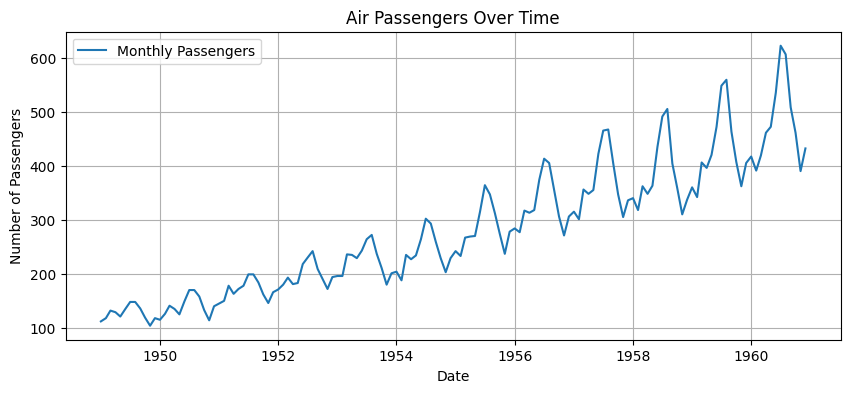

In [2]:
# Rename columns for easier access
df.columns = ['Month', 'Passengers']

# Convert Month to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Plot the original time series
plt.figure(figsize=(10, 4))
plt.plot(df, label='Monthly Passengers')
plt.title('Air Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Passengers']])


In [3]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Use 12 months (1 year) to predict the next month
seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape inputs to (samples, time steps, features)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (105, 12, 1)
y_train shape: (105, 1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0775 - val_loss: 0.2516
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0548 - val_loss: 0.1672
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0351 - val_loss: 0.0932
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0211 - val_loss: 0.0334
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0116 - val_loss: 0.0205
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - val_loss: 0.0248
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067 - val_loss: 0.0274
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - val_loss: 0.0211
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0068 - val_loss: 0.0212
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071 - val_loss: 0.0215
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067 - val_loss: 0.0228
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0055 - val_loss: 0.0225
E

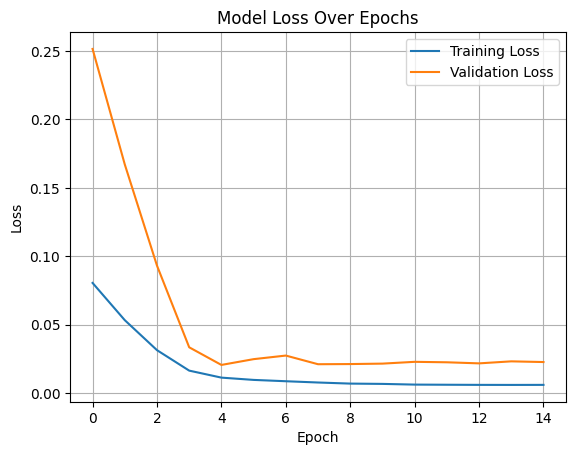

In [4]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


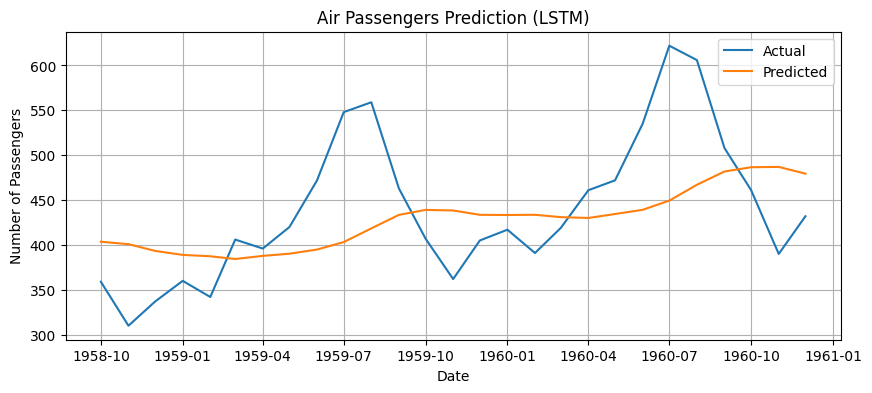

In [5]:
# Make predictions
predicted = model.predict(X_test)

# Inverse transform predictions and actual values
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test)

# Create a time index for the test set predictions
test_dates = df.index[seq_length + len(X_train):]

# Plot actual vs predicted values
plt.figure(figsize=(10, 4))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, predicted, label='Predicted')
plt.title('Air Passengers Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()
